# Estimating expression signatures of cell types using integrated immune organ reference

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import glob
from re import sub

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   

## 1. Loading single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/b_t_cells_tonsils_hk/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/lymph_nodes_analysis/'

In [10]:
sc_data_folder + "slo_preproc_scaled_bbknn_leiden_annotated.h5ad"

'/nfs/team205/vk7/sanger_projects/cell2location_dev/notebooks/data/b_t_cells_tonsils_hk/slo_preproc_scaled_bbknn_leiden_annotated.h5ad'

Read single cell data. We need to make sure gene IDs on both spatial and reference objects are of the same type - gene SYMBOL.

Trying to set attribute `.obs` of view, copying.


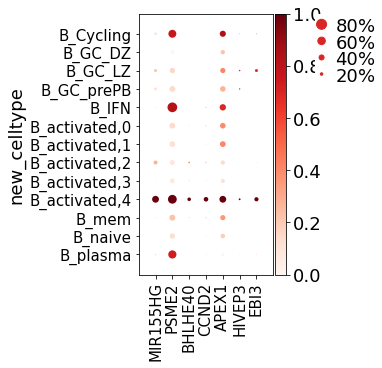

Index(['Age', 'BCELL_CLONE', 'BCELL_CLONE_SIZE', 'Donor', 'ID', 'IGH_MU_FREQ',
       'ISOTYPE', 'LibraryID', 'Method', 'Population', 'PrelimCellType',
       'Sample', 'Sex', 'Study', 'Tissue', 'barcode', 'batch', 'doublet_score',
       'index', 'predicted_doublet', 'percent_mito', 'n_counts', 'n_genes',
       'S_score', 'G2M_score', 'phase', 'VDJsum', 'cell_cycle_diff',
       'PrelimCellType_new', 'leiden', 'leiden_1', 'leiden_2', 'leiden_3',
       'leiden_4', 'CellType', 'CellType2', 'Subset', 'Subset_Broad',
       'Subset_all', 'new_celltype', 'Subset_int', 'Subset_print'],
      dtype='object')

In [11]:
# read single cell data
adata_snrna_raw = anndata.read(sc_data_folder + "slo_preproc_scaled_bbknn_leiden_annotated.h5ad")

# rename erroneourly assigned cell names
adata_snrna_raw.obs['Subset'].cat.rename_categories({
    'ILC': 'Mast', 'Mast': 'ILC', 'T_Tfr': 'T_TfR'
}, inplace=True)

# consolidate annotations
adata_snrna_raw.obs['Subset_all'] = adata_snrna_raw.obs['Subset'].copy()
adata_snrna_raw.obs['Subset'] = adata_snrna_raw.obs['Subset'].astype(str)
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset'].isin(
    ['Endo_ACKR1+', 'Endo_CXCL12+', 'Endo_Lymphatic'])] = ['Endo']
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset'].isin(
    ['NK', 'NK CX3CR1+'])] = ['NK']
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset'].isin(
    ['B_IFN_mem', 'B_IFN_naive'])] = ['B_IFN']
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset'].isin(
    ['B_mem', 'B_mem_FCRL4+'])] = ['B_mem']

adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset'].isin(
    ['B_Cycling', 'T_Cycling'])] = ['B_Cycling']

adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['leiden'].isin(
    ['6'])] = ['B_GC_LZ']
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['leiden'].isin(
    ['13'])] = ['B_GC_DZ']
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['Subset_all'].isin(
    ['B_GC_prePB'])] = ['B_GC_prePB']

adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['Subset'].isin(['Doublet_Mac/B']), :]

adata_snrna_raw.obs['Subset'] = adata_snrna_raw.obs['Subset'].astype('category')

#Perform leiden clustering within the activated B cell cluster
sc.tl.leiden(adata_snrna_raw, resolution=0.6, 
             restrict_to=['Subset', list(['B_activated'])],
             key_added ='new_celltype')
#subset B cells to visualise marker genes more clearly
bcells = adata_snrna_raw[adata_snrna_raw.obs['Subset'].isin(['B_Cycling', 'B_GC_DZ','B_GC_IZ',
                                                             'B_GC_LZ','B_GC_prePB','B_IFN','B_activated',
                                                             'B_mem','B_mem_FCRL4+','B_naive','B_plasma'])]
#These markers adata_snrna_raw be most highly enriched in a preGC cluster
rcParams["axes.facecolor"] = "white"
sc.pl.dotplot(bcells, ['MIR155HG','PSME2','BHLHE40','CCND2','APEX1','HIVEP3','EBI3'],
              groupby='new_celltype', standard_scale="var");

#For me "B_activated,4" corresponded to the preGC state
adata_snrna_raw.obs['Subset'] = adata_snrna_raw.obs['Subset'].astype(str)
adata_snrna_raw.obs['Subset'][adata_snrna_raw.obs['new_celltype'].isin(
    ['B_activated,4'])] = ['B_preGC']

adata_snrna_raw.obs['Subset'] = adata_snrna_raw.obs['Subset'].astype('category')
adata_snrna_raw.obs['Subset_int'] = adata_snrna_raw.obs['Subset'].cat.codes.astype('category')
adata_snrna_raw.obs['Subset_print'] = [str(adata_snrna_raw.obs['Subset_int'][i]) \
                                             + '_' + str(adata_snrna_raw.obs['Subset'][i])
                                             for i in range(adata_snrna_raw.shape[0])]

adata_snrna_raw.obs.columns

In [12]:
list(adata_snrna_raw.obs['Subset'].unique())

['T_CD4+_TfH',
 'T_CD4+_naive',
 'T_CD8+_CD161+',
 'T_CD4+_TfH_GC',
 'DC_CCR7+',
 'T_Treg',
 'T_CD4+',
 'T_TfR',
 'T_CD8+_cytotoxic',
 'Macrophages_M2',
 'B_mem',
 'T_CD8+_naive',
 'T_TIM3+',
 'B_naive',
 'Mast',
 'ILC',
 'NK',
 'B_Cycling',
 'NKT',
 'DC_pDC',
 'B_plasma',
 'DC_cDC2',
 'Monocytes',
 'B_activated',
 'DC_cDC1',
 'Macrophages_M1',
 'Endo',
 'VSMC',
 'B_IFN',
 'B_GC_LZ',
 'B_GC_DZ',
 'B_preGC',
 'FDC',
 'B_GC_prePB']

In [13]:
adata_snrna_raw.obs.groupby(["Study", "Method"]).size()

Study       Method
James_2020  3GEX      10250
            5GEX       4184
King_2020   3GEX       2002
            5GEX      27703
Park_2020   3GEX      15506
            5GEX      13615
dtype: int64

### Select genes using expression in non-zero cells

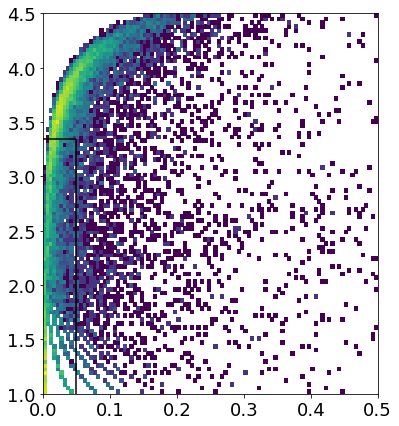

In [14]:
# Select cells
#min_genes = 1000  
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.raw.var['n_cells'] = (adata_snrna_raw.raw.X.toarray() > 0).sum(0)
adata_snrna_raw.raw.var['nonz_mean'] = adata_snrna_raw.raw.X.toarray().sum(0) / adata_snrna_raw.raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.raw.shape[0] * 0.0001)
cell_count_cutoff2 = np.log10(adata_snrna_raw.raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

In [15]:
sel_ind = ((np.array(np.log10(adata_snrna_raw.raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.raw.var['n_cells']) > cell_count_cutoff2))
          & np.array(np.log10(adata_snrna_raw.raw.var['n_cells']) > cell_count_cutoff))
adata_snrna_raw.raw[:,sel_ind].shape

(73260, 10237)

In [16]:
# Create new object with selected genes (shared via our data portal)
# select genes based on mean expression in non-zero cells
adata_snrna_raw_new = sc.AnnData(adata_snrna_raw.raw[:,sel_ind].X)
adata_snrna_raw_new.obs = adata_snrna_raw.obs
adata_snrna_raw_new.var = adata_snrna_raw.raw.var.loc[sel_ind,:]
adata_snrna_raw_new.obsm = adata_snrna_raw.obsm
adata_snrna_raw_new.uns = adata_snrna_raw.uns
adata_snrna_raw_new.obsp = adata_snrna_raw.obsp
adata_snrna_raw_new.varm = adata_snrna_raw.raw.varm

adata_snrna_raw = adata_snrna_raw_new.copy()
adata_snrna_raw.raw = adata_snrna_raw

In [17]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 73260 × 10237
    obs: 'Age', 'BCELL_CLONE', 'BCELL_CLONE_SIZE', 'Donor', 'ID', 'IGH_MU_FREQ', 'ISOTYPE', 'LibraryID', 'Method', 'Population', 'PrelimCellType', 'Sample', 'Sex', 'Study', 'Tissue', 'barcode', 'batch', 'doublet_score', 'index', 'predicted_doublet', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'VDJsum', 'cell_cycle_diff', 'PrelimCellType_new', 'leiden', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'CellType', 'CellType2', 'Subset', 'Subset_Broad', 'Subset_all', 'new_celltype', 'Subset_int', 'Subset_print'
    var: 'GeneID-2', 'GeneName-2', 'feature_types', 'feature_types-0', 'feature_types-1', 'gene_ids-1', 'gene_ids-4861STDY7135913-0', 'gene_ids-4861STDY7135914-0', 'gene_ids-4861STDY7208412-0', 'gene_ids-4861STDY7208413-0', 'gene_ids-Human_colon_16S7255677-0', 'gene_ids-Human_colon_16S7255678-0', 'gene_ids-Human_colon_16S8000484-0', 'gene_ids-Pan_T7935494-0', 'genome-1', 'n_cells', 'nonz_mean'
    uns: 'A

## 2. Show UMAP of cells

... storing 'Subset_print' as categorical


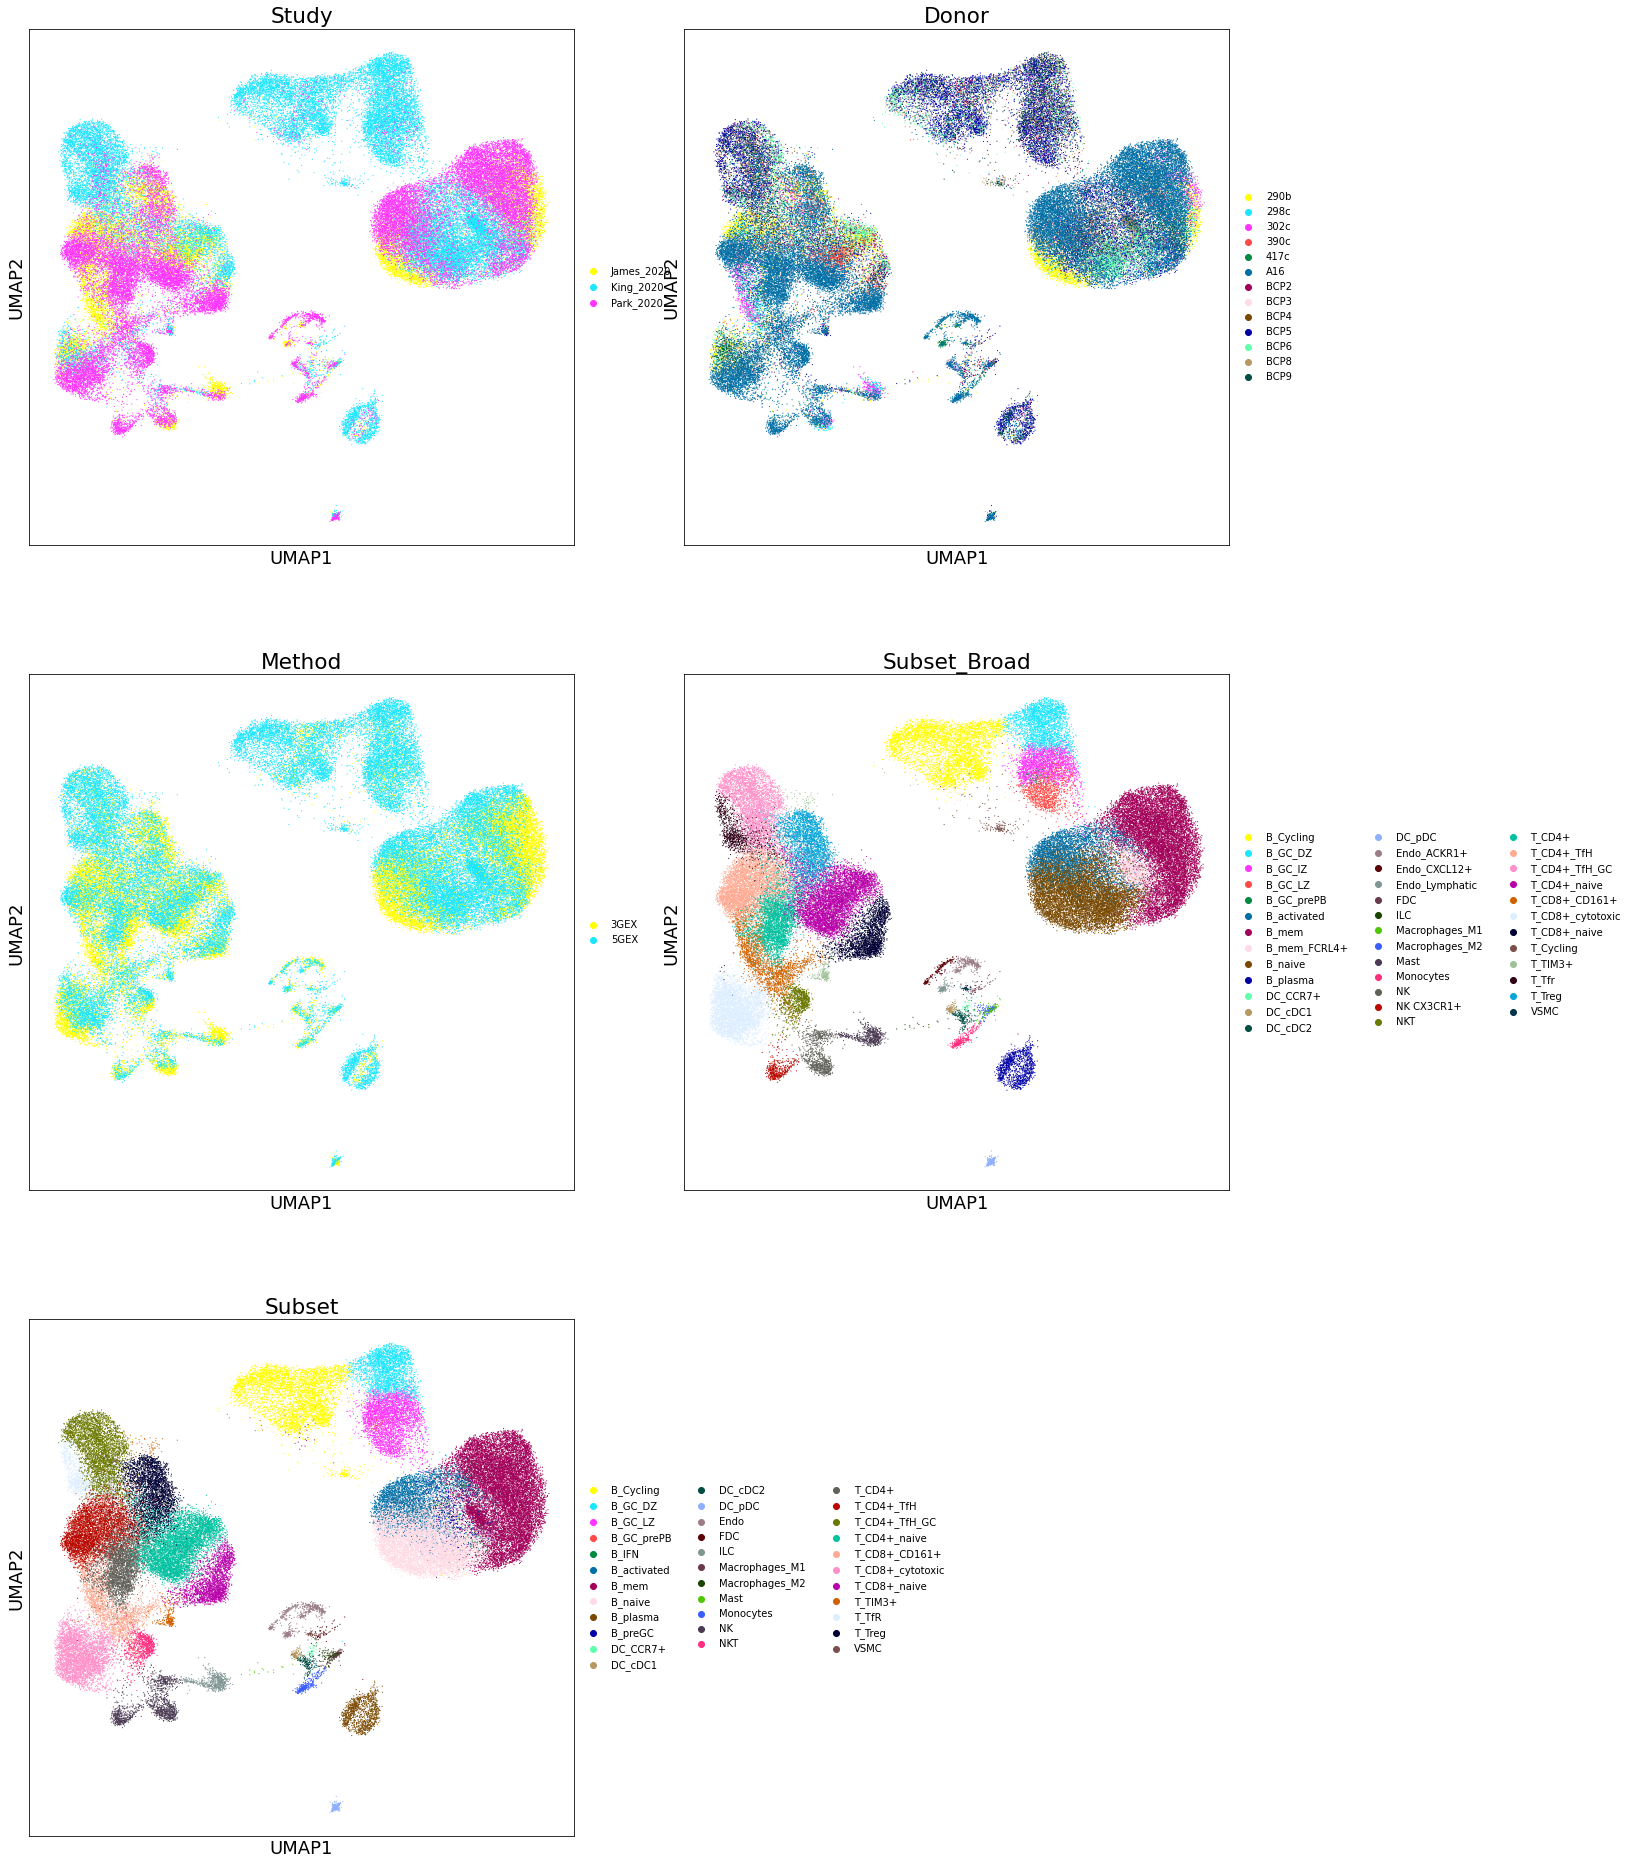

In [37]:
rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw, color=["Study", 'Donor', 'Method', 'Subset_Broad', 'Subset'],
           color_map = 'RdPu', ncols = 2, size=5, #legend_loc='on data',
           legend_fontsize=10, palette=sc.pl.palettes.default_102)

### Estimate reference expression signatures of cell types

### Creating model ### - time 0.05 min
### Analysis name: RegressionNBV4Torch_57covariates_73260cells_10237genes
### Training model to determine n_epochs with CV ###


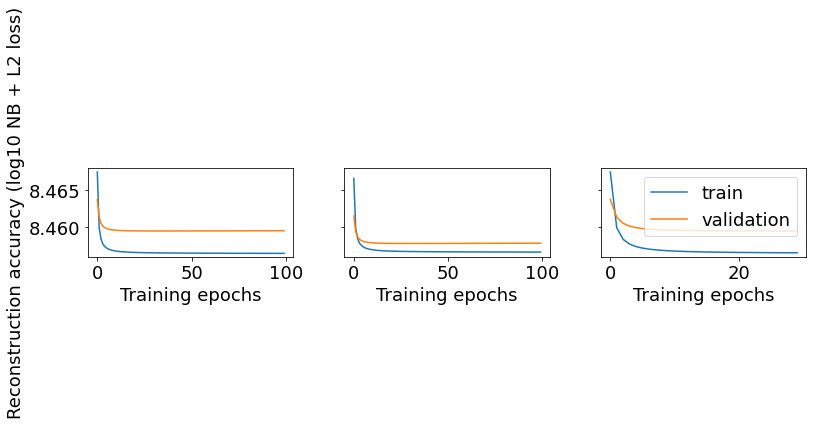

### Re-training model to stop before overfitting ###


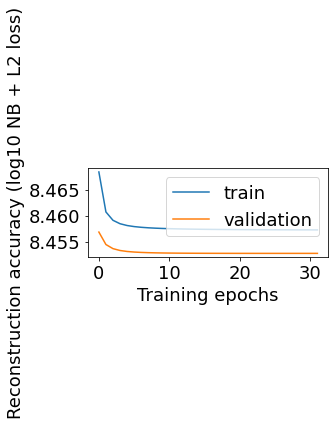

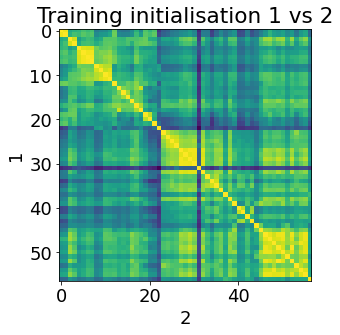

### Evaluating parameters / sampling posterior ### - time 11.98 min


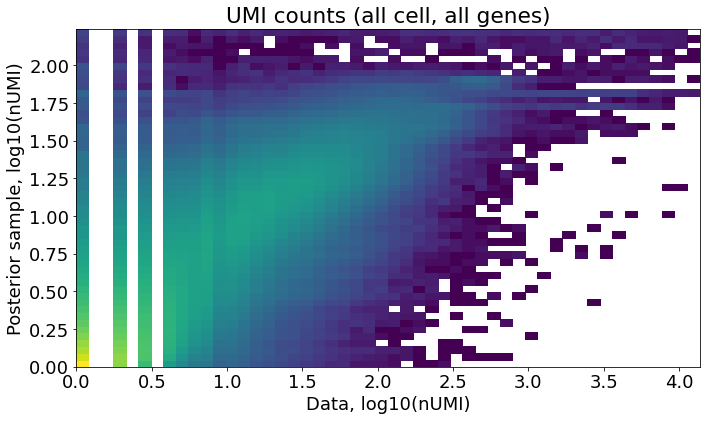

### Saving results ###
### Plotting results ###


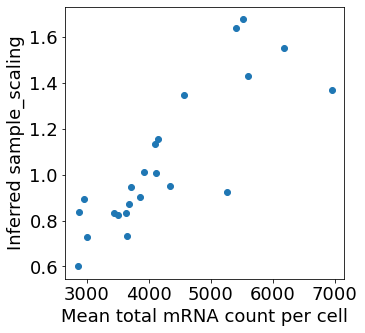

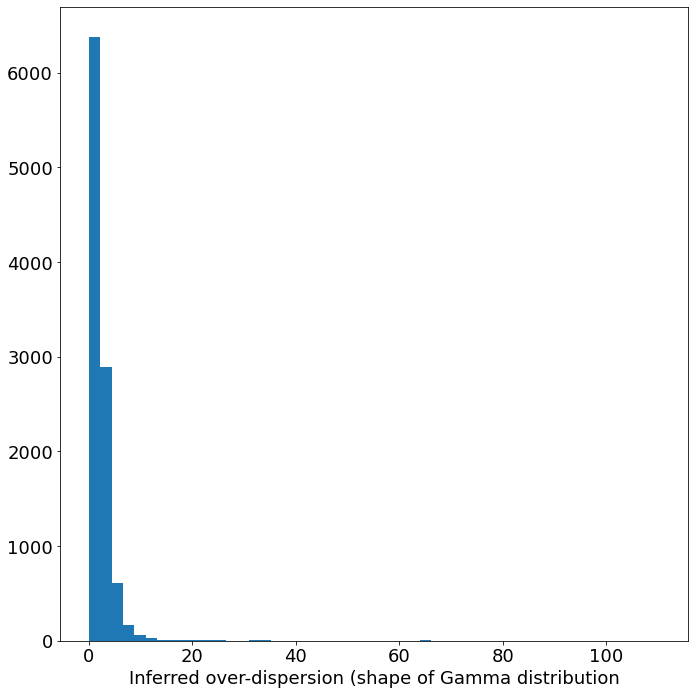

### Done ### - time 13.43 min


In [39]:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, 
                   model_name='RegressionNBV4Torch',
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['Subset'], 
                    'sample_name_col': 'Sample',
                    'tech_name_col': 'Method', 
                    'stratify_cv': 'Subset',
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_average_as_initial_value': True, 'use_cuda': True,
                       
                    'train_proportion': 0.9,
                    
                    'l2_weight': {'l2_weight': 0.001, 'sample_scaling_weight': 0.5,
                                  'gene_overdisp_weight': 0.01},  # True = use defaults for the model
                    
                    'readable_var_name_col': None, 'use_raw': True},
                                 
                   model_kwargs={},
                   posterior_args={},
                                 
                   export_args={'path': results_folder + 'regression_model/', 'save_model': True,
                                'run_name_suffix': ''})

reg_mod = r['mod']

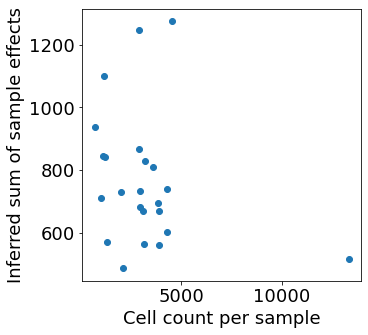

In [23]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata_snrna_raw.obs['Sample'].value_counts()
cell_count.index = ['mean_sample_effectSample_' + i for i in cell_count.index] 

soup_amount = reg_mod.sample_effects.sum(0) 
plt.scatter(cell_count[soup_amount.index].values.flatten(),
            soup_amount.values.flatten());
plt.xlabel('Cell count per sample'); # fraction of reads in cells
plt.ylabel('Inferred sum of sample effects');

In [ ]:
# read estimated signatures
reg_mod_name = 'RegressionNBV4Torch_57covariates_73260cells_10237genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

In [24]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, ['mean_cov_effect_Subset_'  in i for i in inf_aver.columns]]
from re import sub
inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

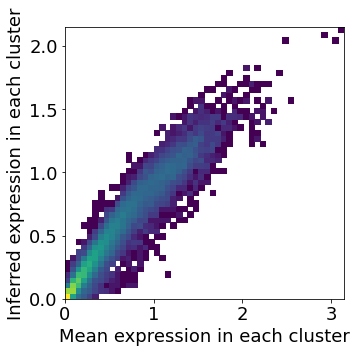

In [25]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'Subset')
aver = aver.loc[adata_snrna_raw.var_names,:]

with matplotlib.rc_context({"figure.figsize": (5,5)}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=matplotlib.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

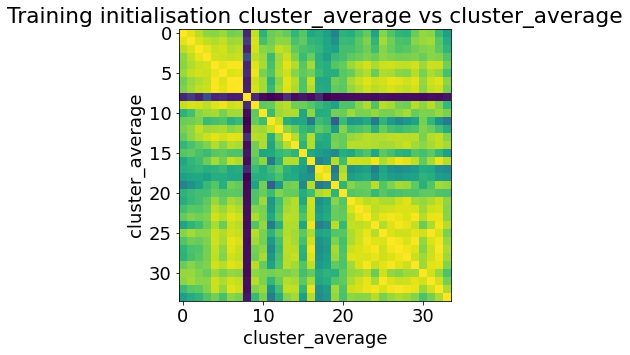

In [27]:
# Correlations in signatures estimated by computing per cluster average of each gene
with matplotlib.rc_context({"figure.figsize": (5,5)}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

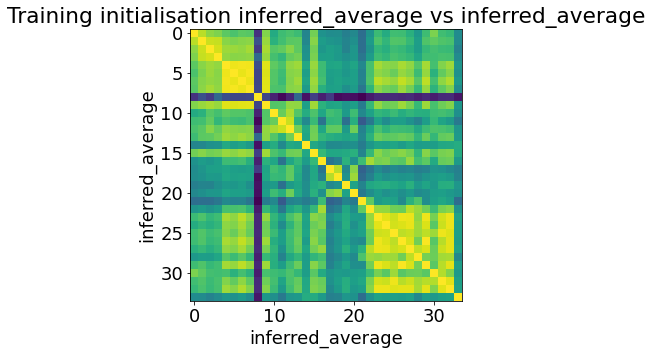

In [28]:
# Correlations in signatures estimated with the model
with matplotlib.rc_context({"figure.figsize": (5,5)}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_average', 'inferred_average', align=False)

In [29]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
adata_snrna_raw_cor.X = reg_mod.normalise(adata_snrna_raw_cor.raw.X)

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.highly_variable_genes(adata_snrna_raw_cor, min_mean=0.0125, max_mean=5, 
                            min_disp=0.5, n_top_genes=5000)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=70, use_highly_variable=True)
sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 70, metric='cosine')

sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.8, spread = 1)

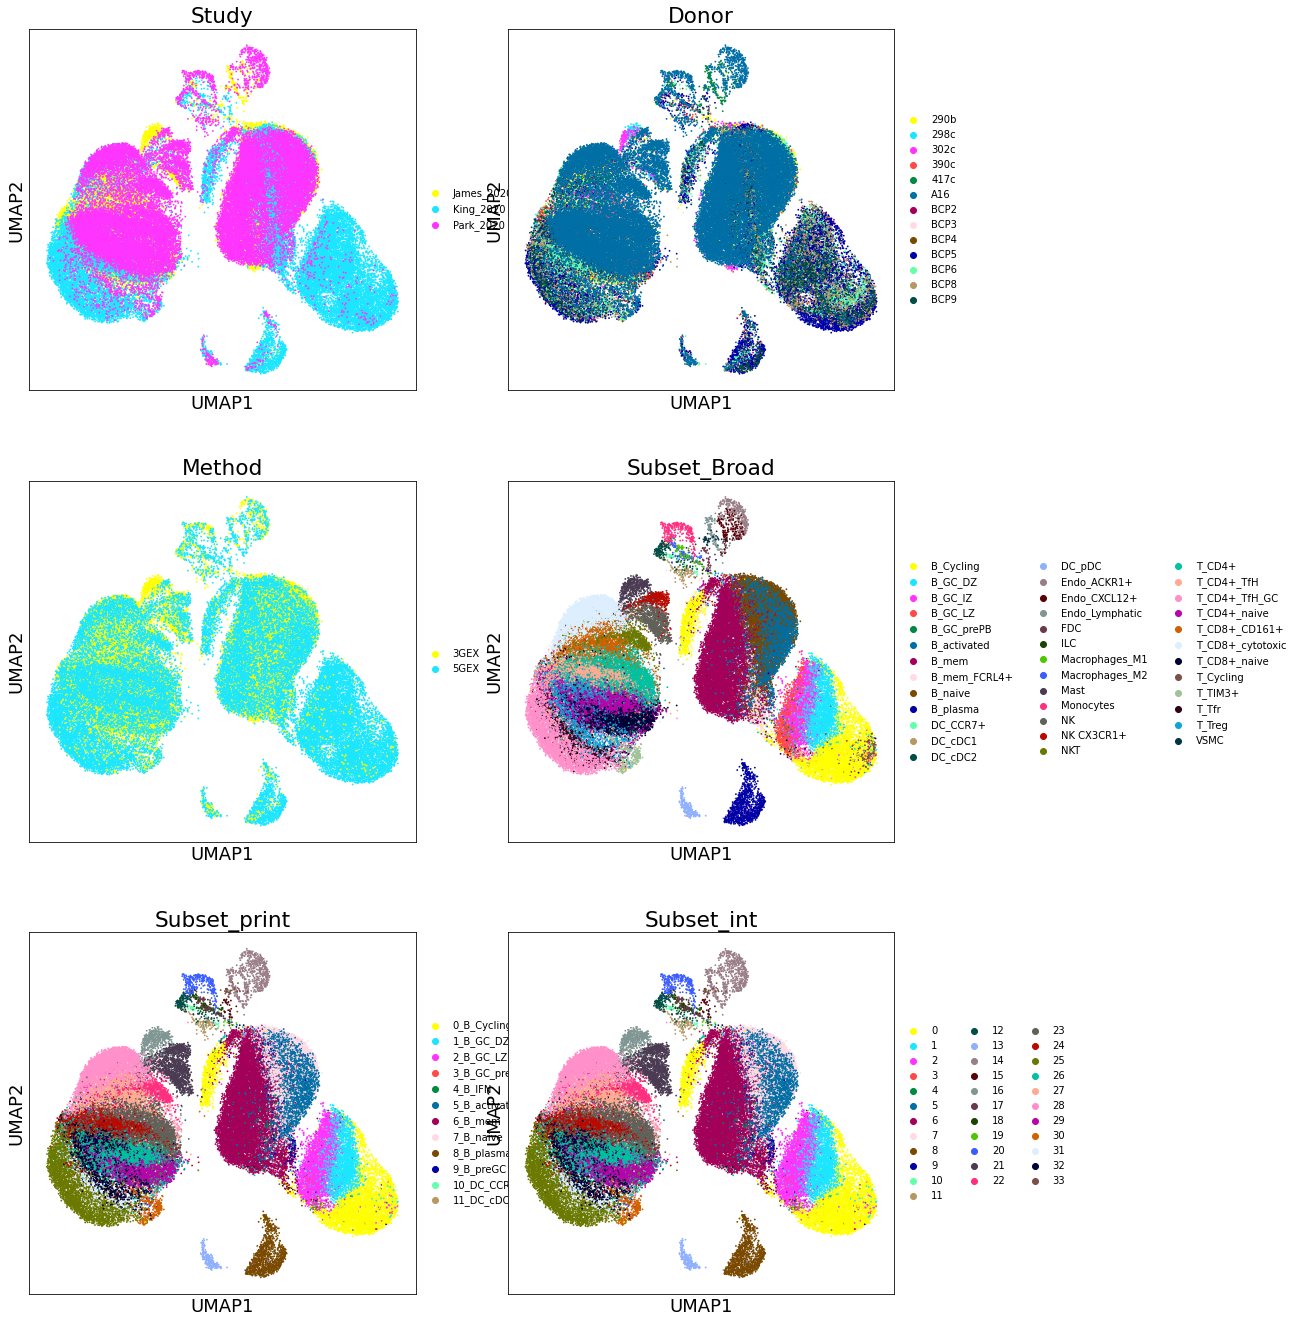

<Figure size 504x504 with 0 Axes>

In [47]:
rcParams['figure.figsize'] = 7, 7
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw_cor, color=["Study", 'Donor', 'Method', 'Subset_Broad', 'Subset_print', 'Subset_int'],
           color_map = 'RdPu', ncols = 2, size=13, #legend_loc='on data',
           legend_fontsize=10, palette=sc.pl.palettes.default_102)
plt.tight_layout()

Modules and their versions used for this analysis

In [96]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.5
wcwidth 0.2.4
pkg_resources._vendor.six 1.10.0
pkg_resources.extern.six 1.10.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_resources._vendor.packaging 16.8
pkg_resources._vendor.packaging.__about__ 16.8
pkg_resources.extern.packaging 16.8
pkg_resources._vendor.pyparsing 2.2.1
pkg_resources.extern.pyparsing 2.2.1
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.1
zmq.sugar.constants 40302
zmq.sugar.version 19.0.1
jupyter_core 4.